# 📓 ACCESS-ESM15-write-zarr

**Author:** Thomas Moore  
**Date:** 2025-10-31
**Updated:** YYYY-MM-DD (if applicable)  
**Environment:** `pangeo_csepta` running on `Gadi` ARE  
**Tags:** sandbox, ARD, ACCESS-ESM1.5

---

### 📘 Description

This notebook attempts to bring together all the disperate workplows for this task over the year(s).  Issue: [https://github.com/Thomas-Moore-Creative/Pacific-Tuna-Climate-Response/issues/51](https://github.com/Thomas-Moore-Creative/Pacific-Tuna-Climate-Response/issues/51) and sub-issues

In [1]:
Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Software

### ACDtools

In [2]:
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=acdtools-0.1-0.editable-py3-none-any.whl size=3553 sha256=aaaa1867aff9c6339b8a589a0960c924b1180c1e8deabefc4e4b62a1fe41f9a0
  Stored in directory: /scratch/es60/thomas_moore/tmp/pip-ephem-wheel-cache-q2koaiiv/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [3]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
%aimport ACDtools.ocean
%aimport ACDtools.plot
# Importing from your local package util.py
from ACDtools import util
from ACDtools import ard
from ACDtools import ocean
from ACDtools import plot

In [12]:
import datetime

## Cluster

In [4]:
client, cluster = util.start_dask_cluster_from_config('netcdf_work')

Cluster started with 28 workers.
Dashboard available at: /proxy/8787/status


## Functions

In [5]:
# develop any new functions here

# settings

In [8]:
job_config_path = '/g/data/es60/users/thomas_moore/code/ACDtools/job_config.yaml'
job_config_dict = ACDtools.util.load_config(job_config_path)

# workflow

In [ ]:
%%time
print('Running ' + job_config_dict['catalog_search_query_dict']['variable_id'] + ' ' + job_config_dict['catalog_search_query_dict']['experiment_id'])

# load catalog
cmip6_fs38_datastore = load_cmip6_CLEX_datastore()
# search catalog for list of files
search = cmip6_fs38_datastore.search(**job_config_dict['catalog_search_query_dict'])
# load into one object using xarray kwags for chunking and handling cftime
####
#ds = load_ACCESS_ESM(search,use_cftime=True,chunking_key=job_config_dict['chunking_key'])
####
ds = load_ACCESS_ESM_ensemble(search,use_cftime=True,chunking_key=job_config_dict['chunking_key'])
# save and drop multidimensional coordinates
ds = save_n_drop_multidim_lat_lon(ds,save_coords_dir=job_config_dict['paths']['save_coords_dir'],variable_name = job_config_dict['catalog_search_query_dict']['variable_id'])
# remove encoding
remove_encoding(ds)
# write out zarr
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print('Started zarr write at '+current_datetime)
filename = f"{job_config_dict['paths']['write_dir']}\
{job_config_dict['catalog_search_query_dict']['source_id']}\
.{job_config_dict['catalog_search_query_dict']['experiment_id']}\
.{job_config_dict['catalog_search_query_dict']['variable_id']}\
.v{current_datetime}.zarr"
ds.to_zarr(filename,consolidated=True)
print('Finished at '+ current_datetime)

In [1]:
import xarray as xr

# setup LocalCluster()

In [2]:
from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster()
client = Client(cluster)

# Load NCI catalog
Follow documentation here: https://opus.nci.org.au/pages/viewpage.action?pageId=213713098

In [3]:
import intake
cmip6_fs38_cat = intake.open_esm_datastore("/g/data/dk92/catalog/v2/esm/cmip6-fs38/catalog.json")

# BELOW cell is manual process of editing the member_id's

# load 10 members of monthly `o2` into one dataset `dict` and concatinate over ensemble members

In [4]:
cmip6_fs38_cat_filtered = cmip6_fs38_cat.search(
    source_id="ACCESS-ESM1-5", 
    experiment_id="historical", 
    table_id="Omon", 
    file_type="f",
    variable_id = "thetao"
)

In [5]:
cmip6_fs38_cat_filtered

,unique
path,680
file_type,1
realm,1
frequency,1
table_id,1
project_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,40


#### what is chunking on NetCDF files? `'chunksizes': (1, 25, 150, 180)`

# DS_dict

In [6]:
xarray_open_kwargs = {"chunks": {"time": 12, "lev": 50, "i" : 360,'j' :300}}

In [7]:
%%time
DS_dict = cmip6_fs38_cat_filtered.to_dataset_dict(progressbar=False,xarray_open_kwargs=xarray_open_kwargs)

CPU times: user 1min 8s, sys: 11.1 s, total: 1min 19s
Wall time: 1min 19s


In [8]:
%%time
DS_concat = xr.concat(
    DS_dict.values(), 
    dim="member"
)

CPU times: user 36.7 s, sys: 3.82 s, total: 40.5 s
Wall time: 1min 28s


# can we simplify to a single DataArray?

In [9]:
DA_concat = DS_concat['thetao']
DA_concat

<xarray.DataArray 'thetao' (member: 40, time: 1980, lev: 50, j: 300, i: 360)> Size: 2TB
dask.array<concatenate, shape=(40, 1980, 50, 300, 360), dtype=float32, chunksize=(1, 12, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Dimensions without coordinates: member
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        Diagnostic should be contributed even for models using co...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello

In [10]:
DS_out = DA_concat.to_dataset()
DS_out

<xarray.Dataset> Size: 2TB
Dimensions:    (time: 1980, lev: 50, j: 300, i: 360, member: 40)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Dimensions without coordinates: member
Data variables:
    thetao     (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>

# drop multi-dimensional coordinates

In [11]:
DS_out = DS_out.drop(['latitude','longitude'])

/jobfs/121717339.gadi-pbs/ipykernel_2339981/742450614.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  DS_out = DS_out.drop(['latitude','longitude'])


In [12]:
DS_out

<xarray.Dataset> Size: 2TB
Dimensions:  (time: 1980, lev: 50, j: 300, i: 360, member: 40)
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * lev      (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j        (j) int32 1kB 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i        (i) int32 1kB 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Dimensions without coordinates: member
Data variables:
    thetao   (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>

# remove encoding

In [13]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [14]:
DS_out.thetao.encoding

{'dtype': dtype('float32'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 1,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 25, 150, 180),
 'preferred_chunks': {'time': 1, 'lev': 25, 'j': 150, 'i': 180},
 'source': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/thetao/gn/files/d20210525/thetao_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-185912.nc',
 'original_shape': (120, 50, 300, 360),
 'missing_value': 1e+20,
 '_FillValue': 1e+20,
 'coordinates': 'latitude longitude'}

In [15]:
remove_zarr_encoding(DS_out)

<xarray.Dataset> Size: 2TB
Dimensions:  (time: 1980, lev: 50, j: 300, i: 360, member: 40)
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * lev      (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j        (j) int32 1kB 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i        (i) int32 1kB 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
Dimensions without coordinates: member
Data variables:
    thetao   (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>

In [16]:
DS_out.thetao.encoding

{}

In [17]:
file_path = '/scratch/es60/ard/models/ACCESS-ESM15/ARD/'

In [18]:
%%time
DS_out.to_zarr(file_path+'ACCESS-ESM1.5-historical-thetao.zarr',consolidated=True)

2024-07-26 14:10:42,579 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:39167 -> tcp://127.0.0.1:33693
Traceback (most recent call last):
  File "/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020

CPU times: user 9min 2s, sys: 1min 8s, total: 10min 11s
Wall time: 51min 38s


In [19]:
result = xr.open_zarr(file_path+'ACCESS-ESM1.5-historical-thetao.zarr',consolidated=True)

In [20]:
result

<xarray.Dataset> Size: 2TB
Dimensions:  (i: 360, j: 300, lev: 50, member: 40, time: 1980)
Coordinates:
  * i        (i) int32 1kB 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j        (j) int32 1kB 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * lev      (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
Dimensions without coordinates: member
Data variables:
    thetao   (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>

In [21]:
temp = result.thetao

CPU times: user 380 ms, sys: 125 ms, total: 505 ms
Wall time: 3.26 s


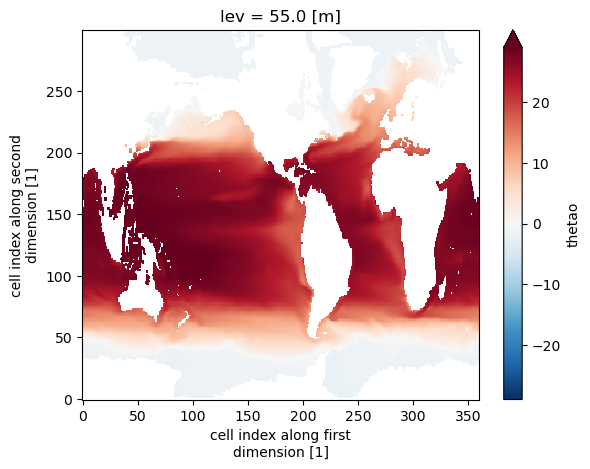

In [22]:
%%time
temp.isel({'member':0,'lev':5}).isel(time=slice(0,12)).mean('time').plot(robust=True)

#### The End (?)

# can we rechunk 40 member collections to `for member`?

In [ ]:
loaded_member1_40_rc = loaded_member1_40.chunk({'member':-1,'time':1,'lev':25})
loaded_member1_40_rc

In [ ]:
remove_zarr_encoding(loaded_member1_40_rc)

In [ ]:
loaded_member1_40_rc.o2.encoding

In [ ]:
%%time
loaded_member1_40_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4member.zarr',consolidated=True)

In [ ]:
chunk4member = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4member.zarr',consolidated=True)

In [ ]:
chunk4member

In [ ]:
chunk4member.o2.max('member').isel(lev=0).mean(dim=['i','j']).plot()

# can we chunk for time?

In [ ]:
loaded_member1_40_rc = loaded_member1_40.chunk({'time':-1,'lev':1,'i':150})
loaded_member1_40_rc

In [ ]:
remove_zarr_encoding(loaded_member1_40_rc)

In [ ]:
loaded_member1_40_rc.o2.encoding

In [ ]:
%%time
loaded_member1_40_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time.zarr',consolidated=True)

In [ ]:
chunked_for_time = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time.zarr',consolidated=True)

In [ ]:
chunked_for_time

In [ ]:
chunked_for_time.o2.mean('time').isel(lev=0).isel(member=0).plot()

# can we chunk for `time & member`?

In [ ]:
chunked_for_time_rc = chunked_for_time.chunk({'time':-1,'lev':1,'member':-1,'i':36,'j':30})
chunked_for_time_rc

In [ ]:
remove_zarr_encoding(chunked_for_time_rc)

In [ ]:
chunked_for_time_rc.o2.encoding

In [ ]:
%%time
chunked_for_time_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time4member.zarr',consolidated=True)

In [ ]:
chunked_for_time_member = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time4member.zarr',consolidated=True)

In [ ]:
chunked_for_time_member

# chunk for 3D space

In [ ]:
loaded_member1_40_rc = loaded_member1_40.chunk({'i':-1,'j':-1,'lev':50,'time':24,'member':1})
loaded_member1_40_rc

In [ ]:
remove_zarr_encoding(loaded_member1_40_rc)

In [ ]:
%%time
loaded_member1_40_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4xyz.zarr',consolidated=True)

In [ ]:
chuned_xyz = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4xyz.zarr',consolidated=True)

In [ ]:
chuned_xyz

In [ ]:
chuned_xyz.o2.mean(dim=['i','j','lev']).plot.line(x="time")

# can we chunk for lev & time?

In [ ]:
chunked_for_time_rc = chunked_for_time.chunk({'time':-1,'lev':-1,'member':1,'i':36,'j':30})
chunked_for_time_rc

In [ ]:
remove_zarr_encoding(chunked_for_time_rc)

In [ ]:
%%time
chunked_for_time_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time4z.zarr',consolidated=True)

In [ ]:
chunked_time_z = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunktime4z.zarr',consolidated=True)

In [ ]:
! rm -rf /scratch/xv83/tm4888/tmp_rechunker/*.zarr # clean up any existing temporary data

In [ ]:
from rechunker import rechunk
target_chunks = {
    "o2": {'member':3,'time':12,'i':360,'j':300,'lev':25},
    "time": None,  # don't rechunk this array
    "i":None,
    "j":None,
    "lev":None,
    "latitude":None,
    "longitude":None
}
max_mem = "2000MB"

target_store = "/scratch/xv83/tm4888/tmp_rechunker/group_rechunked.zarr"
temp_store = "/scratch/xv83/tm4888/tmp_rechunker/group_rechunked-tmp.zarr"
source_group = DS_out

group_plan = rechunk(
    source_group, target_chunks, max_mem, target_store, temp_store=temp_store)
group_plan

In [ ]:
%%time
group_plan.execute()

# Can we open and use this zarr collection?

In [ ]:
data = xr.open_zarr('/scratch/xv83/tm4888/tmp_rechunker/group_rechunked.zarr',consolidated=True)

# can we write to large `zarr` collection?

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/ACCESS_ESM1.5/'

In [ ]:
DS_out = DA_concat_rc.to_dataset()
DS_out

# remove encoding

In [ ]:
for var in DS_out:
    DS_out.encoding = {}

for coord in DS_out.coords:
    DS_out.encoding = {}

In [ ]:
%%time
DS_out.to_zarr(write_path + 'DS_out.zarr',consolidated=True)

# load back in 

In [ ]:
reloaded_data = xr.open_zarr(write_path + 'DS_out.zarr',consolidated=True)

In [ ]:
o2_historical_data

# remove encoding

In [ ]:
for var in o2_historical_data:
    o2_historical_data[var].encoding = {}

for coord in o2_historical_data.coords:
    o2_historical_data[coord].encoding = {}

In [ ]:
o2_historical_surface = o2_historical_data.isel(lev=0)

In [ ]:
o2_historical_surface

In [ ]:
o2_historical_surface_rc = o2_historical_surface.chunk({'member':-1,'time':-1,'i':36,'j':30})

In [ ]:
o2_historical_surface_rc

In [ ]:
%%time
o2_historical_surface_rc.to_zarr(write_path + 'ACCESS_ESM1.5_o2_40_member_surface_chunk4member4time.zarr',consolidated=True)

In [ ]:
data = xr.open_zarr(write_path + 'ACCESS_ESM1.5_o2_40_member_surface_chunk4member4time.zarr',consolidated=True)

In [ ]:
data

In [ ]:
result = (data.o2.max(dim = ['member','time']) - data.o2.mean(dim = ['member','time'])).compute()

In [ ]:
result.plot(robust=True)

In [ ]:
o2_emean = o2_historical_data.mean('member')

In [ ]:
o2_emean

In [ ]:
%%time
o2_emean.to_zarr(write_path + 'ACCESS_ESM1.5_o2_member_mean.zarr',consolidated=True)

# rechunk over member for some box

In [ ]:
box_data = DS_o2_monthly_hist.o2.isel({"lev":10}).sel(i=slice(60,150)).sel(j=slice(60,150))

In [ ]:
box_data

In [ ]:
box_data_rc = box_data.chunk({'member':-1,'time':200})

In [ ]:
box_data_rc

In [ ]:
%%time
box_data_rc.to_netcdf('/scratch/xv83/tm4888/PAC-TUNA/box_data_rc.nc')

In [ ]:
%%time
e_mean = box_data.mean(dim="member").compute()

# ----------------------------

In [ ]:
box_data_rc = xr.open_mfdataset('/scratch/xv83/tm4888/PAC-TUNA/box_data_rc.nc',parallel=True)

In [ ]:
box_data_rc

In [ ]:
%%time
emean = box_data_rc.mean('member').compute()

# Load the production ACCESS-NRI catalogue

In [ ]:
import intake

cat = intake.cat.access_nri

esm_ds = cat["cmip6_fs38"]

esm_ds.esmcat.aggregation_control.groupby_attrs = [
    attrs for attrs in esm_ds.esmcat.aggregation_control.groupby_attrs
    if attrs != "version"
]

esm_ds_filtered = esm_ds.search(
    source_id="ACCESS-ESM1-5", 
    experiment_id="ssp370", 
    table_id="Omon", 
    variable_id="o2", 
    file_type="l"
)

In [ ]:
esm_ds_filtered.unique()['version']

In [ ]:
esm_ds_filtered

In [ ]:
DS_dict = esm_ds_filtered.to_dataset_dict(progressbar=False)
DS_dict

In [ ]:
DS_dict

In [ ]:
DS_o2_monthly_ssp370 = xr.concat(
    DS_dict.values(), 
    dim="member"
)

In [ ]:
DS_o2_monthly_ssp370

In [ ]:
result = DS_o2_monthly_ssp370.o2.isel(lev=20).mean(dim=['i','j'])

In [ ]:
result

In [ ]:
result.plot()

In [ ]:
ds

In [ ]:
esm_ds_filtered['l.CMIP.CSIRO.ACCESS-ESM1-5.ssp585.r9i1p1f1.mon.ocnBgchem.Omon.o2.gn'].df

In [ ]:
esm_ds_filtered.keys()

In [ ]:
esm_ds_filtered['l.CMIP.CSIRO.ACCESS-ESM1-5.ssp585.r40i1p1f1.mon.ocnBgchem.Omon.o2.gn'].df

In [ ]:
import intake

nri_cat = intake.cat.access_nri

In [ ]:
cmip6_fs38_cat = nri_cat['cmip6_fs38']
cmip6_fs38_cat

In [ ]:
ScenarioMIP6_fs38_cat = cmip6_fs38_cat.search(path='/g/data/fs38/publications/CMIP6/ScenarioMIP/*')

In [ ]:
ScenarioMIP6_fs38_cat.unique()['realm']

In [ ]:
ScenarioMIP6_fs38_oceanBGC_cat = ScenarioMIP6_fs38_cat.search(realm=['ocnBgchem'])

In [ ]:
ScenarioMIP6_fs38_oceanBGC_cat

In [ ]:
ScenarioMIP6_fs38_o2_cat = ScenarioMIP6_fs38_oceanBGC_cat.search(variable_id='o2')
ScenarioMIP6_fs38_o2_cat

In [ ]:
ScenarioMIP6_fs38_o2_cat.unique()['frequency']

In [ ]:
ScenarioMIP6_fs38_monthly_o2_cat = ScenarioMIP6_fs38_o2_cat.search(frequency='mon')
ScenarioMIP6_fs38_monthly_o2_cat

In [ ]:
ScenarioMIP6_fs38_monthly_o2_cat.unique()['experiment_id']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_cat = ScenarioMIP6_fs38_monthly_o2_cat.search(experiment_id = 'ssp585')
ScenarioMIP6_fs38_ssp585_monthly_o2_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_cat.unique()['version']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_40e_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_cat.search(version=['v20210831','v20210318'])
ScenarioMIP6_fs38_ssp585_monthly_o2_40e_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_d20210831_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_cat.search(version='d20210831')
ScenarioMIP6_fs38_ssp585_monthly_o2_d20210831_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.df.head()

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.unique()['time_range']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.unique()['member_id']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.search(member_id = 'r40i1p1f1')
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat

In [ ]:
dataset = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat.to_dask(progressbar=False)

In [ ]:
dataset

In [ ]:
dataset['o2'].encoding

In [ ]:
o2_chunked_for_time = dataset.o2.chunk({'time':-1,'lev':25,'i':50,'j':18})

In [ ]:
o2_chunked_for_time

In [ ]:
o2_200m = o2_chunked_for_time.isel(lev=slice(0,21))

In [ ]:
o2_200m

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/'

In [ ]:
o2_200m.to_zarr(write_path + 'ACCESS_ESM1.5_o2_200m_r40i1p1f1.zarr',consolidated=True)

# read back in

In [ ]:
o2 = xr.open_zarr(write_path + 'ACCESS_ESM1.5_o2_200m_r40i1p1f1.zarr',consolidated=True)

In [ ]:
o2

In [ ]:
o2_clim = o2.groupby('time.month').mean()

In [ ]:
o2_clim

In [ ]:
%%time
o2_clim = o2_clim.compute()

In [ ]:
o2_anom = o2.groupby('time.month') - o2_clim

In [ ]:
o2_anom

In [ ]:
PLOT_DATA = o2_anom.o2.isel(time=1031,lev=20)

In [ ]:
%%time
PLOT_DATA = PLOT_DATA.compute()

In [ ]:
import cartopy.crs as ccrs
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
PLOT_DATA.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude"
)
ax.coastlines()
plt.title('o2 December anomaly year 2100\n 205m \n ACCESS_ESM1.5_o2_200m_r40i1p1f1')

In [ ]:
diff = dataset.o2.isel(time=0) - dataset.o2.isel(time=1031)

In [ ]:
diff

In [ ]:
yearly_mean = dataset

In [ ]:
mean_depth_diff = diff.mean('lev')
mean_depth_diff

In [ ]:
import cartopy.crs as ccrs
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
mean_depth_diff.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude"
)
ax.coastlines()
plt.title('depth mean O2 // 

In [ ]:
mean_depth_diff.plot(x=mean_depth_diff['longitude'],y=mean_depth_diff['latitude'])

In [ ]:
source_dict = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.to_source_dict()

In [ ]:
dataset_dict

In [ ]:
dataset_dict.keys()

In [ ]:
ESM15_o2_cat = cmip6_fs38_cat.search(path='/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/*',variable_id = 'o2')

In [ ]:
ESM15_o2_cat

In [ ]:
ESM15_o2_cat.unique()['experiment_id']

In [ ]:
ESM15_o2_cat.unique()['frequency']

In [ ]:
ESM15_monthly_o2_cat = ESM15_o2_cat.search(frequency='mon')

In [ ]:
ESM15_monthly_o2_cat

In [ ]:
ESM15_monthly_o2_cat.unique()['experiment_id']

# Extension BGC run `01deg_jra55v140_iaf_cycle4_jra55v150_extension`

In [ ]:
BGC_extension_cat = nri_cat['01deg_jra55v140_iaf_cycle4_jra55v150_extension']
BGC_extension_cat

# Can we build monthly (or daily) datasets for TEMP and O2 ?

In [ ]:
# show nri cat metadata
nri_cat.metadata

In [ ]:
BGC_extension_cat.search(variable='o2').keys()

In [ ]:
BGC_extension_cat.search(file_id='oceanbgc_3d_o2_1_monthly_mean_4_sigfig_ym_XXXX_XX')

In [ ]:
BGC_extension_cat.df.head()

In [ ]:
monthly_o2 = BGC_extension_cat.search(file_id='oceanbgc_3d_o2_1_monthly_mean_4_sigfig_ym_XXXX_XX')

In [ ]:
monthly_o2_data = monthly_o2.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
monthly_o2_data

In [ ]:
monthly_o2_data.o2.isel({'time':0,'st_ocean':10}).plot()

In [ ]:
daily_o2_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day',variable=['o2'])

In [ ]:
daily_o2_extension_search

In [ ]:
daily_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day')

In [ ]:
daily_extension_search

In [ ]:
daily_extension_search.unique()['variable']

In [ ]:
temp_o2_extension_data = temp_o2_extension_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
temp_o2_extension_data

### MLD test run - COSIMA

In [ ]:
mld_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day',variable='mld')
mld_extension_search

In [ ]:
mld_extension_data = mld_extension_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
mld_extension_data

# Base BGC run `01deg_jra55v140_iaf_cycle4`

In [ ]:
BGC_cat = cat['01deg_jra55v140_iaf_cycle4']
BGC_cat

In [ ]:
mld_search = BGC_cat.search(realm='ocean',frequency='1day',variable='mld')
mld_search

In [ ]:
mld_search.df

In [ ]:
mld_data = mld_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
mld_data

# What do these individual DS's look like?

In [ ]:
mld_data

In [ ]:
mld_extension_data

# Concat base and extension MLD data

In [ ]:
%%time
mld_DS = xr.concat([mld_data,mld_extension_data],dim='time')

In [ ]:
mld_DS

# can we write this to `zarr` on scratch?

In [ ]:
rechunked_mld_DS = mld_DS.chunk({'time':100})

In [ ]:
rechunked_mld_DS

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/'

In [ ]:
%%time
rechunked_mld_DS.to_zarr(write_path+'daily.mld.concat.chunk.100-540-720.zarr', consolidated = True)

In [ ]:
test_read = xr.open_zarr(write_path+'daily.mld.concat.chunk.100-540-720.zarr', consolidated = True)

In [ ]:
test_read

In [ ]:
point = test_read.mld.max(dim=['xt_ocean','yt_ocean'])

In [ ]:
point

In [ ]:
point.plot()

In [ ]:
client.close()